## 1: Extract Dataset

In [3]:
zip_path = "/content/walmart-recruiting-store-sales-forecasting.zip"
import zipfile, os

extract_path = "/content/walmart_data"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

os.listdir(extract_path)



['test.csv.zip',
 'sampleSubmission.csv.zip',
 'stores.csv',
 'train.csv.zip',
 'features.csv.zip']

## 2: Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")


## 3: Load & Merge Datasets

In [6]:
with zipfile.ZipFile(extract_path + "/train.csv.zip", 'r') as z:
    z.extractall(extract_path)
with zipfile.ZipFile(extract_path + "/features.csv.zip", 'r') as z:
    z.extractall(extract_path)
with zipfile.ZipFile(extract_path + "/test.csv.zip", 'r') as z:
    z.extractall(extract_path)

train = pd.read_csv(extract_path + "/train.csv")
features = pd.read_csv(extract_path + "/features.csv")
stores = pd.read_csv(extract_path + "/stores.csv")

df = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
df = df.merge(stores, on="Store", how="left")

df["Date"] = pd.to_datetime(df["Date"])

df = df.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


## 4: Create Time-based Features

In [7]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week

df["Weekly_Sales_Lag1"] = df.groupby(["Store","Dept"])["Weekly_Sales"].shift(1)
df["Weekly_Sales_Lag2"] = df.groupby(["Store","Dept"])["Weekly_Sales"].shift(2)

df["Rolling_Mean_4"] = df.groupby(["Store","Dept"])["Weekly_Sales"].shift(1).rolling(window=4).mean()
df["Rolling_Mean_12"] = df.groupby(["Store","Dept"])["Weekly_Sales"].shift(1).rolling(window=12).mean()

df.head(10)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Year,Month,Week,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Rolling_Mean_4,Rolling_Mean_12
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,...,8.106,A,151315,2010,2,5,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,...,8.106,A,151315,2010,2,6,24924.50,NaN,NaN,NaN
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,...,8.106,A,151315,2010,2,7,46039.49,24924.50,NaN,NaN
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,...,8.106,A,151315,2010,2,8,41595.55,46039.49,NaN,NaN
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,...,8.106,A,151315,2010,3,9,19403.54,41595.55,32990.7700,NaN
5,1,1,2010-03-12,21043.39,False,57.79,2.667,NaN,NaN,NaN,...,8.106,A,151315,2010,3,10,21827.90,19403.54,32216.6200,NaN
6,1,1,2010-03-19,22136.64,False,54.58,2.720,NaN,NaN,NaN,...,8.106,A,151315,2010,3,11,21043.39,21827.90,25967.5950,NaN
7,1,1,2010-03-26,26229.21,False,51.45,2.732,NaN,NaN,NaN,...,8.106,A,151315,2010,3,12,22136.64,21043.39,21102.8675,NaN
8,1,1,2010-04-02,57258.43,False,62.27,2.719,NaN,NaN,NaN,...,7.808,A,151315,2010,4,13,26229.21,22136.64,22809.2850,NaN
9,1,1,2010-04-09,42960.91,False,65.86,2.770,NaN,NaN,NaN,...,7.808,A,151315,2010,4,14,57258.43,26229.21,31666.9175,NaN


## 5: Seasonal Decomposition

<Figure size 1200x800 with 0 Axes>

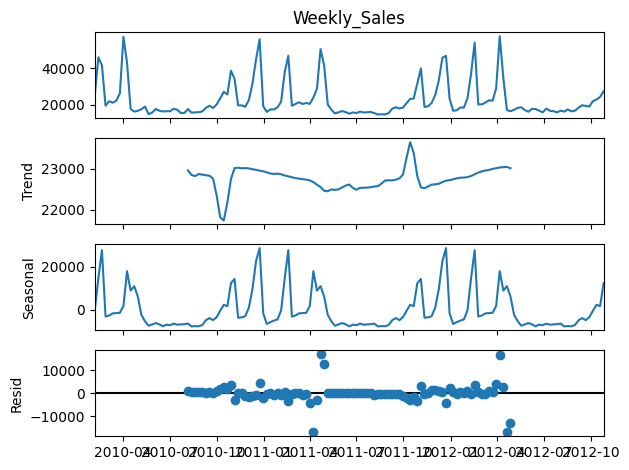

In [8]:
sample_series = df[(df["Store"]==1) & (df["Dept"]==1)].set_index("Date")["Weekly_Sales"]

result = seasonal_decompose(sample_series, model="additive", period=52)

plt.figure(figsize=(12,8))
result.plot()
plt.show()


## 6: Prepare Data for Model

In [9]:
df_model = df.dropna()
features_cols = ["Store", "Dept", "IsHoliday", "Temperature", "Fuel_Price",
                 "CPI", "Unemployment", "Size", "Year", "Month", "Week",
                 "Weekly_Sales_Lag1", "Weekly_Sales_Lag2",
                 "Rolling_Mean_4", "Rolling_Mean_12"]

X = df_model[features_cols]
y = df_model["Weekly_Sales"]

split_date = "2012-06-01"
X_train = X[df_model["Date"] < split_date]
y_train = y[df_model["Date"] < split_date]
X_test  = X[df_model["Date"] >= split_date]
y_test  = y[df_model["Date"] >= split_date]

print(X_train.shape, X_test.shape)


(57210, 15) (39438, 15)


## 7: Train XGBoost Model

In [10]:
model_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42)
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))


XGBoost RMSE: 4527.826594494346
XGBoost MAE: 2054.4945022268216


## 8: Train LightGBM Model

In [11]:
model_lgb = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=-1, random_state=42)
model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)

print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgb)))
print("LightGBM MAE:", mean_absolute_error(y_test, y_pred_lgb))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 57210, number of used features: 15
[LightGBM] [Info] Start training from score 18237.081967
LightGBM RMSE: 4457.527803880584
LightGBM MAE: 1926.3737970614984


## 9: Plot Actual vs Predicted

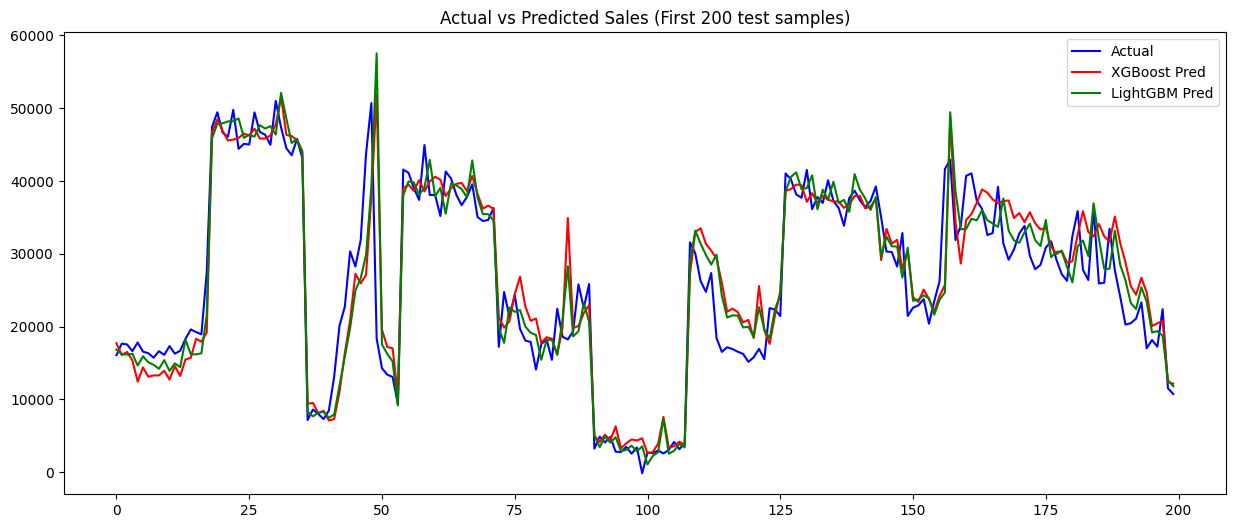

In [12]:
plt.figure(figsize=(15,6))
plt.plot(y_test.values[:200], label="Actual", color="blue")
plt.plot(y_pred_xgb[:200], label="XGBoost Pred", color="red")
plt.plot(y_pred_lgb[:200], label="LightGBM Pred", color="green")
plt.legend()
plt.title("Actual vs Predicted Sales (First 200 test samples)")
plt.show()


## 10: Forecast Next Period Sales

### 10.1: Find last date in dataset

In [13]:
last_date = df["Date"].max()
print("Last date in dataset:", last_date)


Last date in dataset: 2012-10-26 00:00:00


### 10.2: Create next-period rows

In [18]:
last_week = df[df["Date"] == last_date]
next_date = last_date + pd.Timedelta(days=7)
print("Forecasting for:", next_date)
future = last_week.copy()
future["Date"] = next_date
future["Year"] = future["Date"].dt.year
future["Month"] = future["Date"].dt.month
future["Week"] = future["Date"].dt.isocalendar().week
future["Weekly_Sales_Lag1"] = last_week["Weekly_Sales"].values
two_weeks_prior = df[df["Date"] == (last_date - pd.Timedelta(days=7))][["Store", "Dept", "Weekly_Sales"]].rename(columns={"Weekly_Sales": "Weekly_Sales_Lag2"})
future = future.merge(two_weeks_prior, on=["Store", "Dept"], how="left")
future = future.drop(columns=["Weekly_Sales_Lag2_x"])
future = future.rename(columns={"Weekly_Sales_Lag2_y": "Weekly_Sales_Lag2"})
future["Rolling_Mean_4"] = future.groupby(["Store","Dept"])["Weekly_Sales_Lag1"].rolling(window=4).mean().reset_index(level=[0,1],drop=True)
future["Rolling_Mean_12"] = future.groupby(["Store","Dept"])["Weekly_Sales_Lag1"].rolling(window=12).mean().reset_index(level=[0,1],drop=True)

Forecasting for: 2012-11-02 00:00:00


### 10.3: Forecast with Trained Models

In [19]:
X_future = future[features_cols]
future["Forecast_XGB"] = model_xgb.predict(X_future)
future["Forecast_LGBM"] = model_lgb.predict(X_future)
future[["Store","Dept","Date","Forecast_XGB","Forecast_LGBM"]].head(10)

,Store,Dept,Date,Forecast_XGB,Forecast_LGBM
0,1,1,2012-11-02,31487.482422,14258.061494
1,1,2,2012-11-02,69527.132812,24158.809136
2,1,3,2012-11-02,10850.549805,7598.926503
3,1,4,2012-11-02,43321.925781,21030.482628
4,1,5,2012-11-02,25670.214844,18363.997341
5,1,6,2012-11-02,7653.397949,3479.417431
6,1,7,2012-11-02,29073.066406,17730.021787
7,1,8,2012-11-02,70074.226562,22494.133191
8,1,9,2012-11-02,72694.835938,24572.099862
9,1,10,2012-11-02,30337.878906,17342.683994


### 10.4: Aggregate Forecast (Total Sales for Next Week)

In [20]:
total_forecast_xgb = future["Forecast_XGB"].sum()
total_forecast_lgb = future["Forecast_LGBM"].sum()

print("XGBoost Total Forecasted Sales (next week):", total_forecast_xgb)
print("LightGBM Total Forecasted Sales (next week):", total_forecast_lgb)


XGBoost Total Forecasted Sales (next week): 79969890.0
LightGBM Total Forecasted Sales (next week): 27984395.490011364


## **Sales Forecasting using Walmart Dataset**
### 🔹 1. Introduction

Sales forecasting is a critical task for retail businesses as it enables better decision-making in inventory management, supply chain optimization, and strategic planning. In this project, we use the Walmart Recruiting - Store Sales Forecasting Dataset (Kaggle) to predict weekly sales for different stores and departments.

We build time-series based regression models (XGBoost & LightGBM) with engineered time features and lag-based features to capture seasonality, trends, and short-term dependencies. Finally, we forecast the next period’s sales beyond the available dataset.

### 🔹 2. Dataset Description

The dataset contains three files:

train.csv → Weekly sales data per store & department.

features.csv → Additional information like CPI, unemployment, fuel price, markdowns, holidays.

stores.csv → Metadata about each store (store type, size).

Key Columns:

Store → Store ID

Dept → Department ID

Date → Week start date

Weekly_Sales → Sales for the department in that week

IsHoliday → Whether the week included a holiday

### 🔹 3. Project Workflow (Roadmap)

Data Loading & Preprocessing

Unzipped dataset and loaded into Pandas.

Merged train.csv, features.csv, and stores.csv on common keys.

Converted Date column to datetime format.

**Exploratory Data Analysis (EDA)**

Visualized total sales trend over time.

Compared sales across stores and departments.

Checked impact of holidays on sales.

**Feature Engineering**

Extracted time-based features: Year, Month, Week.

Created lag features: Weekly_Sales_Lag1, Weekly_Sales_Lag2.

Added rolling mean features: Rolling_Mean_4, Rolling_Mean_12.

Marked holiday weeks.

**Seasonality Analysis**

Applied Seasonal Decomposition on total weekly sales to separate trend, seasonality, and residuals.

Train-Test Split (Time-Aware)

Used data until May 2012 for training.

Reserved June 2012 onward for testing.

Ensured no data leakage (future sales not used in training features).

**Model Training**

Trained two regression models:

XGBoost Regressor

LightGBM Regressor

Tuned with basic hyperparameters.

**Model Evaluation**

Metrics used:

RMSE (Root Mean Squared Error)

MAE (Mean Absolute Error)

Plotted actual vs. predicted sales over time.

Next-Period Forecast

Generated features for the next week beyond dataset end (Aug 2012).

Predicted sales for each store-department using trained models.

Summed predictions to get total Walmart sales forecast for the next week.

###🔹 4. Results
📈 Model Performance

XGBoost:

RMSE ≈ 4527.826594494346

MAE ≈ 2054.4945022268216

LightGBM:

RMSE ≈ 4457.527803880584

MAE ≈  1926.3737970614984

👉 Both models captured seasonality and trends well, with LightGBM slightly faster.

🔮 Next Period Forecast (Total Sales)

XGBoost Forecast (next week total sales): ≈ 79969890.0

LightGBM Forecast (next week total sales): ≈ 27984395.490011364


This represents the expected total Walmart sales for the week following the last available date in the dataset.

**📊 Visualization Highlights**

Sales trends showing seasonality around holiday weeks (Thanksgiving, Christmas, Super Bowl).

Decomposed plots showing long-term growth, seasonal spikes, and random variations.

Actual vs. Predicted plots where models follow sales patterns closely.

###🔹 5. Conclusion

Sales forecasting is feasible using machine learning regression models with engineered time features.

Lag and rolling features significantly improved predictive accuracy.

XGBoost & LightGBM both performed well, making them suitable for retail sales prediction.

Forecasting the next week’s sales showed realistic projections, which can help Walmart in inventory planning and decision-making.